In [1]:
# Import the libraries
import folium
from folium import IFrame
from folium.plugins import MarkerCluster
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro, skew, kurtosis, zscore
from shapely.geometry import shape
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

### Functions


In [32]:
# Function to Label Encode dataset
def encode_labels(dataset):
    # Check for geometry column and drop it
    if 'geometry' in dataset.columns:
        dataset.drop(['geometry'],axis=1, inplace=True)
    # Create a LabelEncoder
    label_encoder = LabelEncoder()
    for col in dataset.columns:
        if dataset[col].dtype == 'object':
            dataset[col] = label_encoder.fit_transform(dataset[col])
    return dataset

In [33]:
# Create a function to run the models on a dataset
# This is a preliminary function to get the most important features for each model
# So that they can be fed to a clustering model
def run_preliminary_models(data):
    # Split the data into features (X) and target (y)
    X = data.drop(['Price'], axis=1)
    y = data['Price']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize models
    linear_reg = LinearRegression()
    decision_tree = DecisionTreeRegressor(random_state=42)
    random_forest = RandomForestRegressor(random_state=42)
    
    # Fit models
    linear_reg.fit(X_train, y_train)
    decision_tree.fit(X_train, y_train)
    random_forest.fit(X_train, y_train)
    
    # Predictions
    y_pred_linear = linear_reg.predict(X_test)
    y_pred_dt = decision_tree.predict(X_test)
    y_pred_rf = random_forest.predict(X_test)
    
    # Calculate metrics
    mse_linear = mean_squared_error(y_test, y_pred_linear)
    mae_linear = mean_absolute_error(y_test, y_pred_linear)
    r2_linear = r2_score(y_test, y_pred_linear)
    
    mse_dt = mean_squared_error(y_test, y_pred_dt)
    mae_dt = mean_absolute_error(y_test, y_pred_dt)
    r2_dt = r2_score(y_test, y_pred_dt)
    
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    
    # Print metrics
    print("Linear Regression Metrics:")
    print("MSE:", mse_linear)
    print("MAE:", mae_linear)
    print("R^2:", r2_linear)
    print()
    
    print("Decision Tree Metrics:")
    print("MSE:", mse_dt)
    print("MAE:", mae_dt)
    print("R^2:", r2_dt)
    print()
    
    print("Random Forest Metrics:")
    print("MSE:", mse_rf)
    print("MAE:", mae_rf)
    print("R^2:", r2_rf)
    print()
    
    # Get feature importance for Decision Tree and Random Forest
    dt_feature_importance = decision_tree.feature_importances_
    rf_feature_importance = random_forest.feature_importances_
    
    # Select features with importance above threshold (mean)
    sfm_dt = SelectFromModel(decision_tree, threshold='mean')
    sfm_rf = SelectFromModel(random_forest, threshold='mean')
    
    # Transform feature matrices
    X_train_sfm_dt = sfm_dt.fit_transform(X_train, y_train)
    X_train_sfm_rf = sfm_rf.fit_transform(X_train, y_train)
    
    # Get selected feature names
    dt_selected_features = X.columns[sfm_dt.get_support()]
    rf_selected_features = X.columns[sfm_rf.get_support()]
    
    # Print selected features
    print("Selected features for Decision Tree:")
    print(dt_selected_features)
    print()
    
    print("Selected features for Random Forest:")
    print(rf_selected_features)


In [59]:
# Create a function to run the models on a dataset
# This is a preliminary function to get the most important features for each model
# So that they can be fed to a clustering model
def run_preliminary_models(data):
    # Split the data into features (X) and target (y)
    X = data.drop(['Price'], axis=1)
    y = data['Price']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize models
    linear_reg = LinearRegression()
    decision_tree = DecisionTreeRegressor(random_state=42)
    random_forest = RandomForestRegressor(random_state=42)
    
    # Fit models
    linear_reg.fit(X_train, y_train)
    decision_tree.fit(X_train, y_train)
    random_forest.fit(X_train, y_train)
    # Store the split dataset in a dict
    data = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
    # Store the models in a dict
    models = {"Linear Regression": linear_reg, "Decision Tree": decision_tree, "Random Forest": random_forest}
    # Return output as a list of dicts
    output = [data, models]
    return output

In [60]:
# Input is a list of dicts
def get_metrics(input):
    # Get the train test split data
    data = input[0]
    X_test = data['X_test']
    y_test = data['y_test']
    # Get the models
    models = input[1]
    model_metrics = {}
    scores_df = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2'])
    for name, model in models.items():
        # Make predictions
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        scores_df.loc[len(scores_df)] = [name, mse, rmse, mae, r2]
    return scores_df

In [77]:
def get_feature_importance(input):
    # Get the train test split data
    data = input[0]
    X_train = data['X_train']
    # Get the models
    models = input[1]
    feature_importance_df = pd.DataFrame(columns=['Model', 'Feature', 'Importance'])
    for name, model in models.items():
        if isinstance(model, LinearRegression):
            coefficients = model.coef_
            for feature, coefficient in zip(X_train.columns, coefficients):
                feature_importance_df.loc[len(feature_importance_df)] = [name, feature, coefficient]
        elif isinstance(model, DecisionTreeRegressor) or isinstance(model, RandomForestRegressor):
            importances = model.feature_importances_
            for feature, importance in zip(X_train.columns, importances):
                feature_importance_df.loc[len(feature_importance_df)] = [name, feature, importance]
    return feature_importance_df

In [90]:
def get_feature_importance(input):
    # Get the train test split data
    data = input[0]
    X_train = data['X_train']
    # Get the models
    models = input[1]
    feature_importance_df = pd.DataFrame(columns=['Model', 'Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Importance1', 'Importance2', 'Importance3', 'Importance4', 'Importance5'])
    # Iterate through the models and capture their 5 most important features and the feature importance
    for name, model in models.items():
        if isinstance(model, LinearRegression):
            # Feature importance is measured using coefficients in a LinearRegression
            coefficients = model.coef_
            sorted_indices = np.argsort(np.abs(coefficients))[::-1][:5]
            top_features = X_train.columns[sorted_indices]
            top_coefficients = coefficients[sorted_indices]
            feature_importance_df.loc[len(feature_importance_df)] = [name] + top_features.tolist() + [np.nan] * (5 - len(top_features)) + top_coefficients.tolist() + [np.nan] * (5 - len(top_coefficients))
        elif isinstance(model, DecisionTreeRegressor) or isinstance(model, RandomForestRegressor):
            importances = model.feature_importances_
            sorted_indices = np.argsort(importances)[::-1][:5]
            top_features = X_train.columns[sorted_indices]
            top_importances = importances[sorted_indices]
            feature_importance_df.loc[len(feature_importance_df)] = [name] + top_features.tolist() + [np.nan] * (5 - len(top_features)) + top_importances.tolist() + [np.nan] * (5 - len(top_importances))
    return feature_importance_df

In [87]:
encoded_data = encode_labels(housing_dropped)
output = run_preliminary_models(encoded_data)


In [88]:
scores_df = get_metrics(output)
scores_df

,Model,MSE,RMSE,MAE,R2
0,Linear Regression,1.702651e+11,412631.881350,289614.385885,0.514055
1,Decision Tree,1.635562e+11,404420.821077,255145.895409,0.533202
2,Random Forest,7.635600e+10,276325.893887,178250.255528,0.782076


In [89]:
feature_importance = get_feature_importance(output)
feature_importance

,Model,Feature1,Feature2,Feature3,Feature4,Feature5,Importance1,Importance2,Importance3,Importance4,Importance5
0,Linear Regression,Longitude,Latitude,Type,IsWaterfront,Bathroom,1.345654e+06,-1.067264e+06,-372672.517107,346572.310960,234331.667287
1,Decision Tree,Distance,Postcode,Landsize,Bedroom2,Longitude,2.756792e-01,1.843371e-01,0.133331,0.091859,0.058298
2,Random Forest,Distance,Postcode,Landsize,Rooms,Longitude,2.615680e-01,1.925860e-01,0.135601,0.088079,0.068168


In [2]:
# Import the dataset and verify it loaded correctly
housing_df = pd.read_csv("melb_data.csv")

housing_df

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0


In [4]:
# We only want to focus on houses and townhouses
print(housing_df['Type'].unique())
housing_df = housing_df.loc[(housing_df['Type']=='h') | (housing_df['Type']=='t'),:]
print(f"After removing apartments (housing type 'u'), we have {housing_df.shape[0]} rows and {housing_df.shape[1]} columns.")

['h' 't']
After removing apartments (housing type 'u'), we have 10563 rows and 21 columns.


In [5]:
# Fix the misspelled columns
housing_df = housing_df.rename(columns={'Lattitude': 'Latitude','Longtitude': 'Longitude'})

In [6]:
# Get the range of dates
print(housing_df['Date'].tail())
print("We can see that the date range is in the format 'DD/MM/YY'")
print(f"The date range is: {housing_df['Date'].min()}-{housing_df['Date'].max()}")

13575    26/08/2017
13576    26/08/2017
13577    26/08/2017
13578    26/08/2017
13579    26/08/2017
Name: Date, dtype: object
We can see that the date range is in the format 'DD/MM/YY'
The date range is: 1/07/2017-9/09/2017


In [7]:
# Now we will fix the data range and change it to the American standard format
# Create a new copy of the dataset to modify
housing_cleaned = housing_df.copy()
# Adjust the date column to American format MM/DD/YY
housing_cleaned.loc[:,'Date'] = pd.to_datetime(housing_cleaned.loc[:,'Date'], format="%d/%m/%Y")
# Print the date range
print(f" The date range is: {housing_cleaned['Date'].min()} - {housing_cleaned['Date'].max()}")

 The date range is: 2016-01-28 00:00:00 - 2017-09-23 00:00:00


### Remove Missing Values

In [9]:
# Let's check for missing values
housing_cleaned.isna().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                60
Landsize            0
BuildingArea     5017
YearBuilt        4393
CouncilArea      1314
Latitude            0
Longitude           0
Regionname          0
Propertycount       0
dtype: int64

In [10]:
# Now, we will drop columns that contain missing values
housing_dropped = housing_cleaned.copy()
housing_dropped = housing_dropped.dropna(axis=1)
housing_dropped.shape

(10563, 17)

In [11]:
# Create IsWaterfront feature
# Load the gdf
port_phillip_buffer = gpd.read_file("port_phillip_with_buffer.shp")

# Convert lat lon to Point geometries
housing_dropped.loc[:,'geometry'] = housing_dropped.copy().apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

# Initialize the IsWaterfront column
housing_dropped.loc[:,'IsWaterfront'] = 0

# Iterate through the property geometries and check if they intersect with the buffer
for index, property_row in housing_dropped.iterrows():
    property_geometry = property_row['geometry']

    # Check if property interesects with boundary feature
    for boundary_row in port_phillip_buffer.iterrows():
        boundary_geometry = boundary_row[1]['geometry']
        if property_geometry.intersects(boundary_geometry):
            housing_dropped.at[index, 'IsWaterfront'] = 1 # Set IsWaterfront to 1


In [14]:
housing_dropped

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Landsize,Latitude,Longitude,Regionname,Propertycount,geometry,IsWaterfront
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-12-03 00:00:00,2.5,3067.0,2.0,1.0,202.0,-37.79960,144.99840,Northern Metropolitan,4019.0,POINT (144.9984 -37.7996),0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-02-04 00:00:00,2.5,3067.0,2.0,1.0,156.0,-37.80790,144.99340,Northern Metropolitan,4019.0,POINT (144.9934 -37.8079),0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-03-04 00:00:00,2.5,3067.0,3.0,2.0,134.0,-37.80930,144.99440,Northern Metropolitan,4019.0,POINT (144.9944 -37.8093),0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-03-04 00:00:00,2.5,3067.0,3.0,2.0,94.0,-37.79690,144.99690,Northern Metropolitan,4019.0,POINT (144.9969 -37.7969),0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-06-04 00:00:00,2.5,3067.0,3.0,1.0,120.0,-37.80720,144.99410,Northern Metropolitan,4019.0,POINT (144.9941 -37.8072),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,2017-08-26 00:00:00,16.7,3150.0,4.0,2.0,652.0,-37.90562,145.16761,South-Eastern Metropolitan,7392.0,POINT (145.16761 -37.90562),0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,2017-08-26 00:00:00,6.8,3016.0,3.0,2.0,333.0,-37.85927,144.87904,Western Metropolitan,6380.0,POINT (144.87904 -37.85927),0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,2017-08-26 00:00:00,6.8,3016.0,3.0,2.0,436.0,-37.85274,144.88738,Western Metropolitan,6380.0,POINT (144.88738 -37.85274),0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,2017-08-26 00:00:00,6.8,3016.0,4.0,1.0,866.0,-37.85908,144.89299,Western Metropolitan,6380.0,POINT (144.89299 -37.85908),0


## Data Exploration

We will being our data exploration by looking at the distribution of Price and checking its skew and kurtosis.

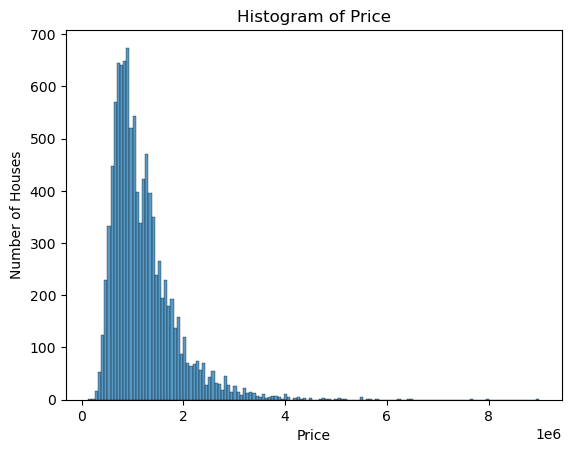

In [92]:
# Create a histogram plot of Price
sns.histplot(data=housing_dropped['Price'])
plt.title('Histogram of Price')
plt.xlabel('Price')
plt.ylabel('Number of Houses')
plt.show()

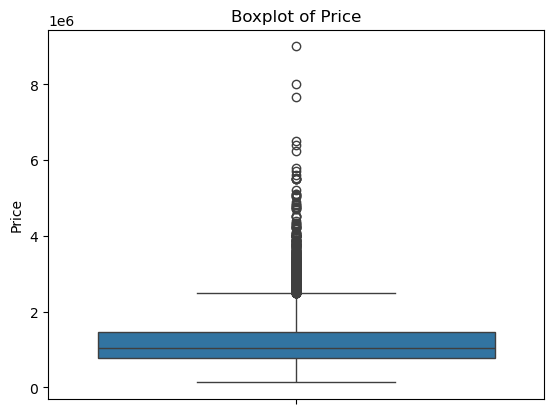

In [93]:
# Create a boxplot of Price
sns.boxplot(data=housing_dropped['Price'])
plt.title('Boxplot of Price')
plt.ylabel('Price')
plt.show()

In [94]:
print(f"The skew of Price is: {housing_dropped['Price'].skew()}")
print(f"The kurtosis of Price is: {housing_dropped['Price'].kurtosis()}")

The skew of Price is: 2.2534340892543265
The kurtosis of Price is: 10.006420101774543


## Price Analysis

We can see that the distribution of Price is positively skewed, with significant outliers in the right tail of the distribution. 

We will apply a logarithmic transform to help normalize the distribution.